#### The goal of this is to produce a house value based on data retrieved from multiple data sources

In [1]:
import pandas as pd
import numpy as np
import math
import sqlite3
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from PostcodeToCoordinates import PostcodeGeocode
import matplotlib
import matplotlib.pyplot as plt
from house_value_estimation import sql_query_to_df

##  Import Data and Setup

In [2]:
# Change this to reading in from the DB

con = sqlite3.connect('cda.db')

cur = con.cursor()

# Query the joined table of both the EPC and land Registry Data (This table is simply called 'merged')

# Set the postcode district to focus on

postcode_district = 'CH1'

query = f"Select * from merged where postcode_district = '{postcode_district}'"

# Convert SQLite3 query to Pandas DataFrame

merged_df = sql_query_to_df(cur, query)


In [6]:
# Perform some additional transformations

merged_df['datetime'] = pd.to_datetime(merged_df['most_recent_transaction'])
merged_df['year'] = merged_df['datetime'].apply(lambda x: x.year)

In [7]:
merged_df.head()

,town,postcode_district,postcode,PAON,street_name,transaction_date,price_paid,query_date,most_recent_transaction,address,address1,house_number,uprn,postcode:1,current_energy_rating,total_floor_area,lodgement_datetime,query_date:1,datetime,year
0,CHESTER,CH1,CH1 1NZ,1,WHITE FRIARS,"Fri, 31 Jul 2015",367500,2022-04-11 21:53:23,"Fri, 31 Jul 2015","1, White Friars","1, White Friars",1,100010034319,CH1 1NZ,E,126.00,2012-09-06 19:15:07,2022-08-01 20:23:12,2015-07-31,2015
1,CHESTER,CH1,CH1 1QG,1,KNIGHTSBRIDGE COURT,"Thu, 18 Aug 2011",155950,2022-04-11 21:52:53,"Thu, 18 Aug 2011","1, Knightsbridge Court","1, Knightsbridge Court",1,200000831553,CH1 1QG,D,59.33,2009-07-08 15:00:29,2022-08-01 20:23:12,2011-08-18,2011
2,CHESTER,CH1,CH1 1RA,1,THE SHIPGATE,"Fri, 25 Apr 2008",275000,2022-04-11 21:52:36,"Fri, 25 Apr 2008","1, The Shipgate, Shipgate Street","1, The Shipgate",1,100012350837,CH1 1RA,D,120.00,2015-02-20 18:09:13,2022-08-01 20:23:12,2008-04-25,2008
3,CHESTER,CH1,CH1 1RH,1,STEELE STREET,"Tue, 04 Jul 2017",225000,2022-04-11 21:55:01,"Tue, 04 Jul 2017","1, Steele Street","1, Steele Street",1,100010029310,CH1 1RH,D,73.00,2017-03-01 19:05:11,2022-08-01 20:23:12,2017-07-04,2017
4,CHESTER,CH1,CH1 1RQ,1,ALBION MEWS,"Fri, 08 Jul 2011",115000,2022-04-11 21:52:53,"Fri, 08 Jul 2011","1 Albion Mews, Albion Street",1 Albion Mews,1,100012346286,CH1 1RQ,E,40.68,2010-06-25 18:33:26,2022-08-01 20:23:12,2011-07-08,2011


In [8]:
len(merged_df)

4856

/tmp/ipykernel_557483/449218521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['price_paid'] = df_21['price_paid'].apply(lambda x: int(x))


<AxesSubplot:ylabel='Density'>

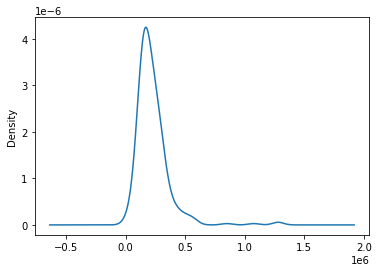

In [10]:
### Examine most recent year - 2021 in this instance
# Change to examine year in date time rather than int val?

df_21 = merged_df[merged_df['year']==2021]

df_21['price_paid'] = df_21['price_paid'].apply(lambda x: int(x))

df_21['price_paid'].plot.kde()

In [18]:
# How many records are in the 2021 dataset?

len(df_21)

302

In [11]:
df_21['price_paid'].describe()

count    3.020000e+02
mean     2.248445e+05
std      1.445652e+05
min      1.840000e+03
25%      1.450000e+05
50%      1.900000e+05
75%      2.700000e+05
max      1.280000e+06
Name: price_paid, dtype: float64

## 1. Linear Regression Model

In [14]:
### Build Model based on the relationship between price paid and area

# Training data
X = np.array(df_21['total_floor_area'])
X = X.reshape(-1, 1)

# Target data
y = np.array(df_21['price_paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [15]:
test = np.array([50])
test = test.reshape(-1,1)
regressor.predict(test)

array([[122582.11016175]])

/tmp/ipykernel_557483/1637155546.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_test,y_pred, 'k-', color = 'r')


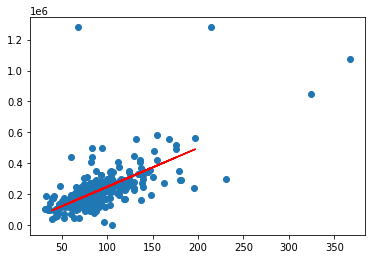

Coefficients: 
 [[2510.88870364]]
Mean squared error: 4416832774.99
Coefficient of determination: 0.60
MAPE: 0.40


In [17]:
# Plot linear regression

plt.scatter(df_21['total_floor_area'],df_21['price_paid'])
plt.plot(X_test,y_pred, 'k-', color = 'r')
plt.show()

# The coefficients
print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# The mean absolute percentage error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

### 1.2 Exclude Outliers

In [19]:
## Can we improve this by removing outliers?
# Remove values beyond 3 standard deviations in floor area and price

rm = df_21[np.abs(df_21['total_floor_area']-df_21['total_floor_area'].mean()) <= (3*df_21['total_floor_area'].std())]
rm = rm[np.abs(df_21['price_paid']-rm['price_paid'].mean()) <= (3*rm['price_paid'].std())]

/tmp/ipykernel_557483/856157725.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rm = rm[np.abs(df_21['price_paid']-rm['price_paid'].mean()) <= (3*rm['price_paid'].std())]


In [20]:
### Build Model based on the relationship between price paid and area

# Training data
X = np.array(rm['total_floor_area'])
X = X.reshape(-1, 1)

# Target data
y = np.array(rm['price_paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)

y_pred = lin_regressor.predict(X_test)

/tmp/ipykernel_132172/894081485.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_test,y_pred, 'k-', color = 'r')


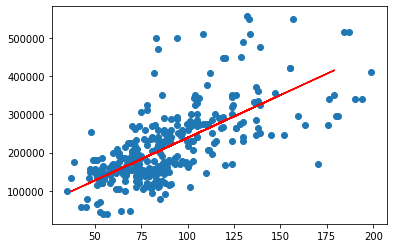

Coefficients: 
 [[2229.46144111]]
Mean squared error: 3084189196.63
Coefficient of determination: 0.39
MAPE: 0.23


In [24]:
# Plot linear regression

plt.scatter(rm['total-floor-area'],rm['Price Paid'])
plt.plot(X_test,y_pred, 'k-', color = 'r')
plt.show()

# The coefficients
print("Coefficients: \n", lin_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# The mean absolute percentage error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

Removing outliers (beyond 3 standard deviations) for both Price Paid and total-floor-area significantly decreased the mean squared error (MSE), however, the Coefficient of determination (R-Squared) has increased.

## 2. Multiple Linear Regression Model

In [21]:
### Adjust features and data format

## Use one-hot encoding to classify for property type

for i in df_21['property-type'].dropna().unique():
    var_name = 'is'+i
    df_21[var_name] = np.where(df_21['property-type']==i,1,0)
    
## Convert categorical to numerical


rating_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6, 
    'G':7
}

# Replace null values with most frequent value
mode_val = df_21['current-energy-rating'].value_counts().index[0]
df_21['current-energy-rating'] = df_21['current-energy-rating'].fillna(value = mode_val)
df_21['rating_num'] = df_21['current-energy-rating'].apply(lambda x: rating_dict[x])

## Number of Habitable Rooms
# Replace null values with median

def clean_rooms(x):
    if isinstance(x,float):
        return x
    else:
        return np.nan
    
df_21['number-habitable-rooms'] = df_21['number-habitable-rooms'].apply(clean_rooms)
med_val = np.median(df_21['number-habitable-rooms'].dropna())

df_21['number-habitable-rooms'] = df_21['number-habitable-rooms'].fillna(value = med_val)

df_21['room-size'] = df_21['total-floor-area']/df_21['number-habitable-rooms']


KeyError: 'property-type'

In [15]:
### Geocode the postcode

df_21['lat'], df_21['long'] = PostcodeGeocode((df_21['postcode']))

df_21['lat'] = df_21['lat'].astype(float)

df_21['long'] = df_21['long'].astype(float)

### Identify distance from Railway Station/Town Centre

chester_station = [53.196502, -2.880304]

chester_town = [53.190249, -2.891639]

# Returns distance in degrees using simple euclidean distance

def distance_station(lat,long, feature = chester_station):
    return math.sqrt((feature[0]-lat)**2 + (feature[1]-long)**2)

def distance_town(lat,long, feature = chester_town):
    return math.sqrt((feature[0]-lat)**2 + (feature[1]-long)**2)

df_21['distance-station'] = list(map(distance_station,df_21['lat'],df_21['long']))
df_21['distance-town'] = list(map(distance_town,df_21['lat'],df_21['long']))


/tmp/ipykernel_132172/3866665377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['lat'], df_21['long'] = PostcodeGeocode((df_21['postcode']))
/tmp/ipykernel_132172/3866665377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['lat'] = df_21['lat'].astype(float)
/tmp/ipykernel_132172/3866665377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [52]:
### Build Model based on the relationship between price paid and area

# Training data
X = np.array(df_21[['total-floor-area','isHouse','isFlat','rating_num','room-size']])


# Target data
y = np.array(df_21['Price Paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

# The coefficients
print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))# The mean absolute percentage error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

Coefficients: 
 [[  2071.6044139  -23562.31110892   1692.45658481   1217.36340565
    7665.300791  ]]
Mean squared error: 5213037367.14
Coefficient of determination: 0.49
MAPE: 0.34


Despite engineering a number of additional features to be used in this model, this did not help reduce the mean squared error. In fact, more data only decreased the coefficient of determination and increased the MSE suggesting that adding more data is not going to help improve the prediction. 

Producing a correlation matrix like the one below can help identify potential linear relationships better than trial and error. It's worth noting that the feature with the second highest correlation score, "room-size", is derivative of "total-floor-area". While this chart can help identify correlation, it can't warn about multicollinearity. 

In [18]:
### Plot a correlation matrix

## Focus on specific numeric attributes

attributes = df_21[['Price Paid','rating_num','distance-station','distance-town','number-habitable-rooms','total-floor-area','room-size']]

corr = attributes.corr()
corr.style.background_gradient(cmap='coolwarm')

,Price Paid,rating_num,distance-station,distance-town,number-habitable-rooms,total-floor-area,room-size
Price Paid,1.000000,0.031377,0.110035,0.094238,0.345912,0.724232,0.625064
rating_num,0.031377,1.000000,0.039032,0.022530,0.079824,0.069603,0.029301
distance-station,0.110035,0.039032,1.000000,0.975299,0.129921,0.194524,0.120107
distance-town,0.094238,0.022530,0.975299,1.000000,0.095313,0.185486,0.142080
number-habitable-rooms,0.345912,0.079824,0.129921,0.095313,1.000000,0.650467,-0.085040
total-floor-area,0.724232,0.069603,0.194524,0.185486,0.650467,1.000000,0.672428
room-size,0.625064,0.029301,0.120107,0.142080,-0.085040,0.672428,1.000000


## 3. Random Forest Regressor

In [90]:
### Set up Random Forest model

# Training data
X = np.array(df_21[['total-floor-area','isHouse','isFlat','isBungalow','isMaisonette','rating_num','room-size','distance-station','distance-town']])


# Target data
y = np.array(df_21['Price Paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regr = RandomForestRegressor(max_depth = 100)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of Determination: %.2f" % regr.score(X_test, y_test))

# The mean absolute percentage error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

/tmp/ipykernel_132172/2953273281.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


Mean squared error: 9790521761.06
Coefficient of Determination: 0.05
MAPE: 0.24


In [91]:
# Change to predict percent difference from the linear prediction

arr = np.array(df_21['total-floor-area'].values)
arr = arr.reshape(-1, 1)

df_21['predicted Price Paid'] = lin_regressor.predict(arr)

df_21['Price Paid Difference'] = df_21['predicted Price Paid']-df_21['Price Paid']

df_21['Pct Difference'] = (df_21['Price Paid Difference']/df_21['Price Paid'])*100

/tmp/ipykernel_132172/358704791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['predicted Price Paid'] = lin_regressor.predict(arr)
/tmp/ipykernel_132172/358704791.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['Price Paid Difference'] = df_21['predicted Price Paid']-df_21['Price Paid']
/tmp/ipykernel_132172/358704791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [93]:
df_21[['Price Paid Difference','predicted Price Paid','Price Paid','Pct Difference']].head()

,Price Paid Difference,predicted Price Paid,Price Paid,Pct Difference
20734,-12923.641353,319076.358647,332000,-3.892663
22635,-33674.326554,156325.673446,190000,-17.723330
22809,17798.745501,267798.745501,250000,7.119498
23223,82603.286591,207603.286591,125000,66.082629
23350,-17201.254499,267798.745501,285000,-6.035528


In [84]:
for i in df_21.columns:
    print(i)

url
Price Paid
Transaction Date
Transaction Id
Type
About
PAON
Postcode
Street Name
datetime
year
postcode_number
lmk-key
address1
address2
address3
postcode
building-reference-number
current-energy-rating
potential-energy-rating
current-energy-efficiency
potential-energy-efficiency
property-type
built-form
inspection-date
local-authority
constituency
county
lodgement-date
transaction-type
environment-impact-current
environment-impact-potential
energy-consumption-current
energy-consumption-potential
co2-emissions-current
co2-emiss-curr-per-floor-area
co2-emissions-potential
lighting-cost-current
lighting-cost-potential
heating-cost-current
heating-cost-potential
hot-water-cost-current
hot-water-cost-potential
total-floor-area
energy-tariff
mains-gas-flag
floor-level
flat-top-storey
flat-storey-count
main-heating-controls
multi-glaze-proportion
glazed-type
glazed-area
extension-count
number-habitable-rooms
number-heated-rooms
low-energy-lighting
number-open-fireplaces
hotwater-descripti

In [103]:
### Set up Random Forest model

# Training data
X = np.array(df_21[['isHouse','isFlat','rating_num','room-size']])


# Target data
y = np.array(df_21['Pct Difference'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regr = RandomForestRegressor(max_depth = 100, bootstrap = True)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

print("Coefficient of Determination: %.2f" % regr.score(X_test, y_test))

# The mean absolute percentage error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

/tmp/ipykernel_132172/2465052643.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


Mean squared error: 1268.19
Coefficient of Determination: 0.19
MAPE: 1.55


In [104]:
df_21[['isHouse','isFlat','rating_num','room-size','Pct Difference']].head()

,isHouse,isFlat,rating_num,room-size,Pct Difference
20734,1,0,3,22.666667,-3.892663
22635,0,1,3,12.600000,-17.723330
22809,1,0,4,22.600000,7.119498
23223,1,0,3,17.200000,66.082629
23350,1,0,4,18.833333,-6.035528


In [102]:
len(df_21)

368

In [101]:
regr.predict(np.array([[1,0,3,22.66]]))

array([15.03832545])

In [97]:
X

array([[ 1.        ,  0.        ,  3.        , 22.66666667],
       [ 0.        ,  1.        ,  3.        , 12.6       ],
       [ 1.        ,  0.        ,  4.        , 22.6       ],
       ...,
       [ 1.        ,  0.        ,  4.        , 19.71428571],
       [ 1.        ,  0.        ,  5.        , 21.        ],
       [ 1.        ,  0.        ,  3.        , 20.2       ]])